# Deep Learning - Autoencoder with Regularization
Aluno: Lucas Mendes Massa

Implement an autoencoder with a single hidden layer. Reconstruct inputs for the Ionosphere data set of the previous exercise with:

(a) no added noise and weight regularization,

(b) added Gaussian noise and no weight regularization.

## Lendo a base de dados e separando entre datasets de treino e teste

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import Callback, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [4]:
X, y = df.values[:, :-1], df.values[:, -1]
X = X.astype('float32')
X = (X - np.min(X))/(np.max(X) - np.min(X)) # normalize data
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Autoencoder com regularizacao

In [38]:
def create_model(number_of_features, hidden_size):
    input_array = layers.Input(shape=(number_of_features))
    input_layer = layers.Dense(number_of_features, activation='relu')(input_array)
    encoded = layers.Dense(hidden_size, activation='relu')(input_layer)
    decoded = layers.Dense(number_of_features, activation='sigmoid', kernel_regularizer=regularizers.l2())(encoded)
    
    autoencoder = Model(input_array, [decoded, encoded])
    return autoencoder

In [ ]:
def calculate_mean_error(model, data):
    mse = 0
    for i in range(len(data)):
        input_data = data[i].reshape((1, data.shape[1]))
        pred = np.squeeze(model(input_data)[0])
        real = data[i]
        mse += mean_squared_error(pred, real)
    return mse/data.shape[0]

In [50]:
autoencoder = create_model(X.shape[1], 32)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss=[losses.MeanSquaredError(), None])

history = autoencoder.fit(x=X_train, y=X_train, epochs=300, batch_size=16, verbose=1)

Epoch 1/300
16/16 [==============================] - 1s 7ms/step - loss: 0.4013 - dense_29_loss: 0.0925
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.3474 - dense_29_loss: 0.0841
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 0.3012 - dense_29_loss: 0.0772
Epoch 4/300
16/16 [==============================] - 0s 3ms/step - loss: 0.2608 - dense_29_loss: 0.0700
Epoch 5/300
16/16 [==============================] - 0s 3ms/step - loss: 0.2260 - dense_29_loss: 0.0637
Epoch 6/300
16/16 [==============================] - 0s 3ms/step - loss: 0.1971 - dense_29_loss: 0.0596
Epoch 7/300
16/16 [==============================] - 0s 3ms/step - loss: 0.1730 - dense_29_loss: 0.0571
Epoch 8/300
16/16 [==============================] - 0s 3ms/step - loss: 0.1529 - dense_29_loss: 0.0558
Epoch 9/300
16/16 [==============================] - 0s 3ms/step - loss: 0.1358 - dense_29_loss: 0.0544
Epoch 10/300
16/16 [==============================] - 0s 3ms/ste

In [51]:
calculate_mean_error(autoencoder, X_train)

0.013808168634316142

In [52]:
calculate_mean_error(autoencoder, X_test)

0.02724494093058209

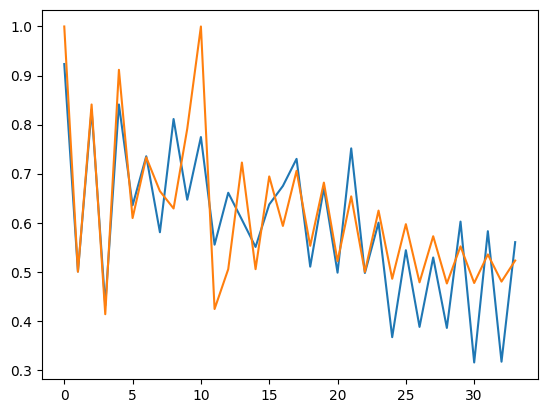

In [53]:
input_data = X_test[0].reshape((1, X_test.shape[1]))
pred = np.squeeze(autoencoder(input_data)[0])
real = np.squeeze(input_data)
plt.plot(pred)
plt.plot(real)
plt.show()

## Autoencoder sem regularizacao e com adicao de ruido gaussiano aos dados

In [60]:
noise = np.random.normal(0, 0.1, X_train.shape)
noisy_train = X_train + noise

noise = np.random.normal(0, 0.1, X_test.shape)
noisy_test = X_test + noise

In [61]:
def create_model_noisy(number_of_features, hidden_size):
    input_array = layers.Input(shape=(number_of_features))
    input_layer = layers.Dense(number_of_features, activation='relu')(input_array)
    encoded = layers.Dense(hidden_size, activation='relu')(input_layer)
    decoded = layers.Dense(number_of_features, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_array, [decoded, encoded])
    return autoencoder

In [65]:
def calculate_mean_error_noisy(model, data, noisy_data):
    mse = 0
    for i in range(len(data)):
        input_data = noisy_data[i].reshape((1, data.shape[1]))
        pred = np.squeeze(model(input_data)[0])
        real = data[i]
        mse += mean_squared_error(pred, real)
    return mse/data.shape[0]

In [66]:
autoencoder_noisy = create_model_noisy(noisy_train.shape[1], 32)
autoencoder_noisy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss=[losses.MeanSquaredError(), None])

history = autoencoder.fit(x=noisy_train, y=X_train, epochs=300, batch_size=16, verbose=1)

Epoch 1/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0148 - dense_29_loss: 0.0112
Epoch 2/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0144 - dense_29_loss: 0.0109
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0143 - dense_29_loss: 0.0109
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0139 - dense_29_loss: 0.0107
Epoch 5/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0139 - dense_29_loss: 0.0108
Epoch 6/300
16/16 [==============================] - 0s 4ms/step - loss: 0.0139 - dense_29_loss: 0.0109
Epoch 7/300
16/16 [==============================] - 0s 4ms/step - loss: 0.0141 - dense_29_loss: 0.0112
Epoch 8/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0136 - dense_29_loss: 0.0107
Epoch 9/300
16/16 [==============================] - 0s 3ms/step - loss: 0.0137 - dense_29_loss: 0.0108
Epoch 10/300
16/16 [==============================] - 0s 3ms/ste

In [67]:
calculate_mean_error_noisy(autoencoder_noisy, X_train, noisy_train)


0.10203734100701249

In [68]:
calculate_mean_error_noisy(autoencoder_noisy, X_test, noisy_test)


0.10689960584431044

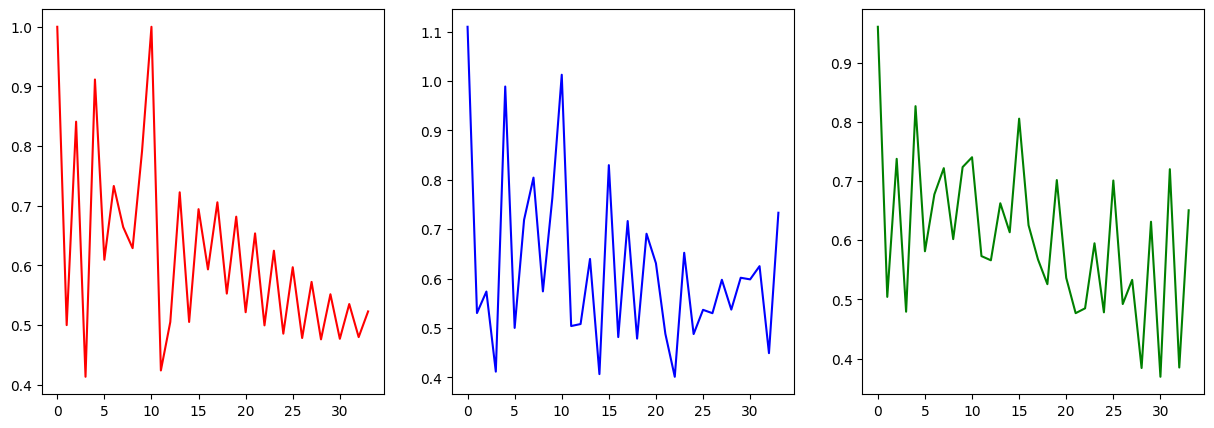

In [71]:
input_data = noisy_test[0].reshape((1, noisy_test.shape[1]))
pred = np.squeeze(autoencoder(input_data)[0])
real =  X_test[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(real, 'r')
ax[1].plot(np.squeeze(input_data), 'b')
ax[2].plot(pred, 'g')